https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1

In [1]:
import numpy as np # linear algebra
import pandas as pd
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("./data"))

['sample_submission.csv', 'test.csv', 'train.csv']


# 数据加载

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
train.head()

,ID,Price,Date,Postcode,Property Type,Old/New,Property Rights,First address,Secondary Address,Street,Locality,Town/City,District,County,Category Type,Record Status
0,0,670000,2019/1/11 0:00,CM3 4BS,D,N,F,FIR TREE COTTAGE,NaN,NORTH HILL,LITTLE BADDOW,CHELMSFORD,CHELMSFORD,ESSEX,A,A
1,1,200000,2019/1/4 0:00,SS3 9RJ,T,N,F,38,NaN,EAGLE WAY,SHOEBURYNESS,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,A
2,2,545000,2019/1/18 0:00,CM3 4UR,D,N,F,9,NaN,LITTLE FIELDS,DANBURY,CHELMSFORD,CHELMSFORD,ESSEX,A,A
3,3,270000,2019/1/11 0:00,SS0 9TY,T,N,F,148,NaN,WESTBOURNE GROVE,NaN,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,A
4,4,367500,2019/1/16 0:00,SS11 7BB,S,N,F,53,NaN,GUERNSEY GARDENS,NaN,WICKFORD,BASILDON,ESSEX,A,A


In [4]:
test.head()

,ID,Date,Postcode,Property Type,Old/New,Property Rights,First address,Secondary Address,Street,Locality,Town/City,District,County,Category Type,Record Status
0,691866,2019/1/4 0:00,N16 6UH,T,N,F,10,NaN,BELFAST ROAD,NaN,LONDON,HACKNEY,GREATER LONDON,B,A
1,691867,2019/1/18 0:00,SW9 9UQ,O,N,F,6,NaN,BELLEFIELDS ROAD,NaN,LONDON,LAMBETH,GREATER LONDON,B,A
2,691868,2019/1/28 0:00,SW6 4EA,O,N,F,29,NaN,WHITTINGSTALL ROAD,NaN,LONDON,HAMMERSMITH AND FULHAM,GREATER LONDON,B,A
3,691869,2019/2/12 0:00,SW17 7LU,S,N,F,25,NaN,BEECHES ROAD,NaN,LONDON,WANDSWORTH,GREATER LONDON,B,A
4,691870,2019/2/12 0:00,E1 1NU,O,N,F,108,NaN,COMMERCIAL ROAD,NaN,LONDON,TOWER HAMLETS,GREATER LONDON,B,A


In [5]:
print ("Train: ",train.shape[0],"sales, and ",train.shape[1],"features")
print ("Test: ",test.shape[0],"sales, and ",test.shape[1],"features")

Train:  691866 sales, and  16 features
Test:  172967 sales, and  15 features


# 特征分析

邮政编码

属性类型

旧/新

产权

第一个地址

二次地址

街

位置

城市/城市

区

县
类别类型

记录状态

In [6]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']  # 数值特征
# quantitative.remove('Price')
# quantitative.remove('ID')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']  # 分类特征

In [7]:
quantitative

['ID', 'Price']

In [8]:
qualitative

['Date ',
 'Postcode',
 'Property Type',
 'Old/New',
 'Property Rights',
 'First address',
 'Secondary Address',
 'Street',
 'Locality',
 'Town/City',
 'District',
 'County',
 'Category Type',
 'Record Status ']

In [9]:
quantitative.remove('Price')
quantitative.remove('ID')
quantitative

[]

哇，全是分类

## 康康缺失值情况

<Axes: >

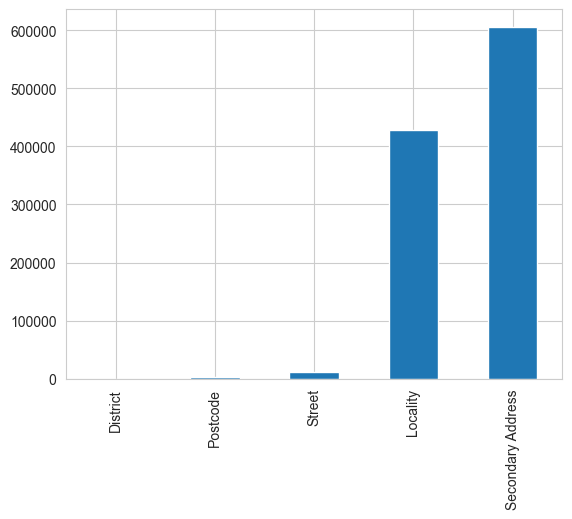

In [10]:
sns.set_style("whitegrid")
missing = train.isnull().sum()  # 计算训练数据集(train)中每个特征列的缺失值数量
missing = missing[missing > 0]  # 选择缺失值数量大于0的特征列
missing.sort_values(inplace=True)  # 按照缺失值数量从小到大排序
missing.plot.bar()

In [11]:
missing_value_ratios = train.isnull().mean()
missing_value_ratios = missing_value_ratios[missing_value_ratios > 0]
missing_value_ratios.sort_values(inplace=True)
missing_value_ratios

District             0.000244
Postcode             0.004708
Street               0.018066
Locality             0.619405
Secondary Address    0.875693
dtype: float64

有五个特征有缺失值，其中Locality与Secondary Address的缺失率都超过了百分之60，可以删除

In [12]:
unique_value_counts = train.nunique()
unique_value_counts = unique_value_counts.drop(['Price', 'ID'])
unique_value_counts.sort_values(inplace=True)
unique_value_counts

Record Status             1
Old/New                   2
Property Rights           2
Category Type             2
Property Type             5
County                  113
District                354
Date                    357
Town/City              1143
Secondary Address      7679
Locality              15374
First address         62371
Street               154962
Postcode             425069
dtype: int64

从中可以看出Record Status只有一个值，可以删掉

其中有像Postcode这样分类比较多的特征不能用传统的方式进行编码

# 特征处理

In [13]:
train_id = train['ID']
test_id = train['ID']
train.drop(['ID', 'Record Status '], axis=1, inplace=True)  # 删‘ID’列
test.drop(['ID', 'Record Status '], axis=1, inplace=True)

In [14]:
# temp = pd.DataFrame(train)
# temp.columns
train.columns

Index(['Price', 'Date ', 'Postcode', 'Property Type', 'Old/New',
       'Property Rights', 'First address', 'Secondary Address', 'Street',
       'Locality', 'Town/City', 'District', 'County', 'Category Type'],
      dtype='object')

In [15]:
train.drop(['Secondary Address'], axis=1, inplace=True)  # 删‘Secondary Address’列
test.drop(['Secondary Address'], axis=1, inplace=True)
train.drop(['Locality'], axis=1, inplace=True)  # 删‘Locality’列
test.drop(['Locality'], axis=1, inplace=True)

In [16]:
train.columns

Index(['Price', 'Date ', 'Postcode', 'Property Type', 'Old/New',
       'Property Rights', 'First address', 'Street', 'Town/City', 'District',
       'County', 'Category Type'],
      dtype='object')

# 使用众数填充缺失值

不用0是因为防止数据太离散，增强模型鲁棒性

In [17]:
train['Postcode'].fillna(train['Postcode'].mode()[0], inplace=True)
test['Postcode'].fillna(test['Postcode'].mode()[0], inplace=True)

train['Street'].fillna(train['Street'].mode()[0], inplace=True)
test['Street'].fillna(test['Street'].mode()[0], inplace=True)

train['District'].fillna(train['District'].mode()[0], inplace=True)
test['District'].fillna(test['District'].mode()[0], inplace=True)

In [18]:
train_missing_after = train.isnull().sum()
test_missing_after = test.isnull().sum()

In [19]:
train_missing_after

Price              0
Date               0
Postcode           0
Property Type      0
Old/New            0
Property Rights    0
First address      0
Street             0
Town/City          0
District           0
County             0
Category Type      0
dtype: int64

In [20]:
test_missing_after

Date               0
Postcode           0
Property Type      0
Old/New            0
Property Rights    0
First address      0
Street             0
Town/City          0
District           0
County             0
Category Type      0
dtype: int64

# 对Price做log变换

In [21]:
train['Price_log'] = np.log1p(train['Price'])

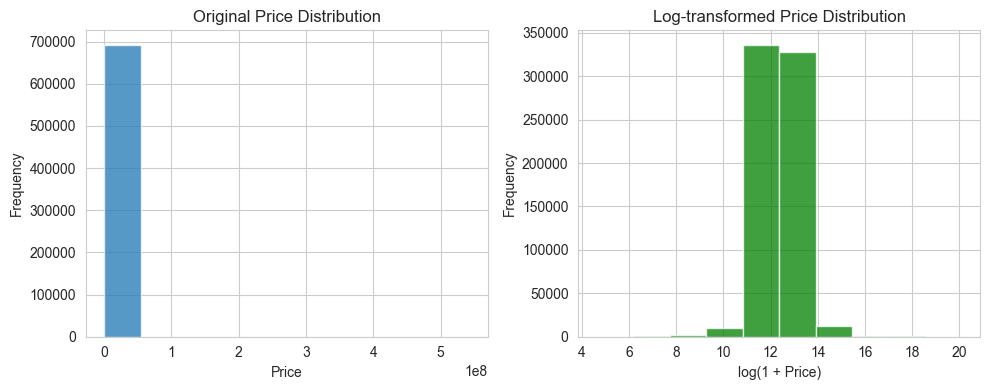

In [22]:
# 创建一个 1x2 的子图布局
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 绘制原始价格数据的直方图
axes[0].hist(train['Price'], bins=10, alpha=0.75)
axes[0].set_title('Original Price Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# 绘制对数变换后的价格数据的直方图
axes[1].hist(train['Price_log'], bins=10, alpha=0.75, color='g')
axes[1].set_title('Log-transformed Price Distribution')
axes[1].set_xlabel('log(1 + Price)')
axes[1].set_ylabel('Frequency')

# 显示图形
plt.tight_layout()
plt.show()

In [23]:
train['Price'] = np.log1p(train['Price'])

In [24]:
train.columns

Index(['Price', 'Date ', 'Postcode', 'Property Type', 'Old/New',
       'Property Rights', 'First address', 'Street', 'Town/City', 'District',
       'County', 'Category Type', 'Price_log'],
      dtype='object')

In [25]:
train.drop(['Price_log'], axis=1, inplace=True)

In [26]:
train.columns

Index(['Price', 'Date ', 'Postcode', 'Property Type', 'Old/New',
       'Property Rights', 'First address', 'Street', 'Town/City', 'District',
       'County', 'Category Type'],
      dtype='object')

#  合并

In [27]:
train_counts = train.shape[0] # 记住训练集行数，后面分割用
test_counts = test.shape[0]

train_Price = train['Price'][:train_counts]  # 后面会将训练数据与目标值分开来训练，在drop前先存好
train_features = train.drop(['Price'], axis=1)
test_features = test
features = pd.concat([train_features, test_features]).reset_index(drop=True)
plt.show()

In [28]:
features.shape

(864833, 11)

# Date

date特征相对于其他特征来说比较复杂，得好好处理

将其处理成'Month'和'Day'特征。

对于'Month'特征，我们可以将其转换为季节信息，以反映季节性因素对房价的影响。例如，我们可以将'Winter'、'Spring'、'Summer'和'Fall'等季节信息作为新的特征进行建模。

对于'Day'特征，我们可以将其转换为星期几信息，以反映周末和工作日对房价的影响。例如，我们可以将'Weekday'和'Weekend'等星期几信息作为新的特征进行建模。

In [29]:
features.head()

,Date,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Category Type
0,2019/1/11 0:00,CM3 4BS,D,N,F,FIR TREE COTTAGE,NORTH HILL,CHELMSFORD,CHELMSFORD,ESSEX,A
1,2019/1/4 0:00,SS3 9RJ,T,N,F,38,EAGLE WAY,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A
2,2019/1/18 0:00,CM3 4UR,D,N,F,9,LITTLE FIELDS,CHELMSFORD,CHELMSFORD,ESSEX,A
3,2019/1/11 0:00,SS0 9TY,T,N,F,148,WESTBOURNE GROVE,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A
4,2019/1/16 0:00,SS11 7BB,S,N,F,53,GUERNSEY GARDENS,WICKFORD,BASILDON,ESSEX,A


In [30]:
features['Date '] = pd.to_datetime(features['Date '])

# 提取月、日新特征
features['Month'] = features['Date '].dt.month
features['Day'] = features['Date '].dt.day

在新特征'Month'和'Day'中，我们可以考虑进一步提取有用的信息

对于'Month'特征，我们可以将其转换为季节信息，以反映季节性因素对房价的影响。例如，我们可以将'Winter'、'Spring'、'Summer'和'Fall'等季节信息作为新的特征进行建模。

对于'Day'特征，我们可以将其转换为星期几信息，以反映周末和工作日对房价的影响。例如，我们可以将'Weekday'和'Weekend'等星期几信息作为新的特征进行建模。

In [31]:
features.head()

,Date,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Category Type,Month,Day
0,2019-01-11,CM3 4BS,D,N,F,FIR TREE COTTAGE,NORTH HILL,CHELMSFORD,CHELMSFORD,ESSEX,A,1,11
1,2019-01-04,SS3 9RJ,T,N,F,38,EAGLE WAY,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,1,4
2,2019-01-18,CM3 4UR,D,N,F,9,LITTLE FIELDS,CHELMSFORD,CHELMSFORD,ESSEX,A,1,18
3,2019-01-11,SS0 9TY,T,N,F,148,WESTBOURNE GROVE,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,1,11
4,2019-01-16,SS11 7BB,S,N,F,53,GUERNSEY GARDENS,WICKFORD,BASILDON,ESSEX,A,1,16


In [32]:
# 提取'Month'特征，转换为季节信息
seasons = [(1, 'Winter'), (4, 'Spring'), (7, 'Summer'), (10, 'Fall')]
bins = [1, 4, 7, 10, 13]
labels = [name for _, name in seasons]
features['Season'] = pd.cut(features['Date '].dt.month, bins=bins, labels=labels, right=False)

# 提取'Day'特征，转换为星期几信息
features['Weekday'] = features['Date '].dt.weekday
features['Weekend'] = features['Weekday'].isin([5, 6]).astype(int)

In [33]:
features.head()

,Date,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Category Type,Month,Day,Season,Weekday,Weekend
0,2019-01-11,CM3 4BS,D,N,F,FIR TREE COTTAGE,NORTH HILL,CHELMSFORD,CHELMSFORD,ESSEX,A,1,11,Winter,4,0
1,2019-01-04,SS3 9RJ,T,N,F,38,EAGLE WAY,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,1,4,Winter,4,0
2,2019-01-18,CM3 4UR,D,N,F,9,LITTLE FIELDS,CHELMSFORD,CHELMSFORD,ESSEX,A,1,18,Winter,4,0
3,2019-01-11,SS0 9TY,T,N,F,148,WESTBOURNE GROVE,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,1,11,Winter,4,0
4,2019-01-16,SS11 7BB,S,N,F,53,GUERNSEY GARDENS,WICKFORD,BASILDON,ESSEX,A,1,16,Winter,2,0


In [34]:
features.columns

Index(['Date ', 'Postcode', 'Property Type', 'Old/New', 'Property Rights',
       'First address', 'Street', 'Town/City', 'District', 'County',
       'Category Type', 'Month', 'Day', 'Season', 'Weekday', 'Weekend'],
      dtype='object')

In [35]:
# 周期性编码
features['Month_cos'] = np.cos(2 * np.pi * features['Month'] / 12)
features['Month_sin'] = np.sin(2 * np.pi * features['Month'] / 12)

features['Day_cos'] = np.cos(2 * np.pi * features['Day'] / 31)
features['Day_sin'] = np.sin(2 * np.pi * features['Day'] / 31)

features['Weekday_cos'] = np.cos(2 * np.pi * features['Weekday'] / 7)
features['Weekday_sin'] = np.sin(2 * np.pi * features['Weekday'] / 7)

# 删除原始的'Date '列
features.drop(['Date '], axis=1, inplace=True)
features.drop(['Month'], axis=1, inplace=True)
features.drop(['Day'], axis=1, inplace=True)
features.drop(['Weekday'], axis=1, inplace=True)

In [36]:
features.head()

,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Category Type,Season,Weekend,Month_cos,Month_sin,Day_cos,Day_sin,Weekday_cos,Weekday_sin
0,CM3 4BS,D,N,F,FIR TREE COTTAGE,NORTH HILL,CHELMSFORD,CHELMSFORD,ESSEX,A,Winter,0,0.866025,0.5,-0.612106,0.790776,-0.900969,-0.433884
1,SS3 9RJ,T,N,F,38,EAGLE WAY,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,Winter,0,0.866025,0.5,0.688967,0.724793,-0.900969,-0.433884
2,CM3 4UR,D,N,F,9,LITTLE FIELDS,CHELMSFORD,CHELMSFORD,ESSEX,A,Winter,0,0.866025,0.5,-0.874347,-0.485302,-0.900969,-0.433884
3,SS0 9TY,T,N,F,148,WESTBOURNE GROVE,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,Winter,0,0.866025,0.5,-0.612106,0.790776,-0.900969,-0.433884
4,SS11 7BB,S,N,F,53,GUERNSEY GARDENS,WICKFORD,BASILDON,ESSEX,A,Winter,0,0.866025,0.5,-0.994869,-0.101168,-0.222521,0.974928


In [37]:
features_unique_value_counts = features.nunique()
features_unique_value_counts.sort_values(inplace=True)
features_unique_value_counts

Old/New                 2
Property Rights         2
Category Type           2
Weekend                 2
Season                  4
Property Type           5
Weekday_sin             7
Weekday_cos             7
Month_sin              11
Month_cos              11
Day_cos                26
Day_sin                31
County                113
District              354
Town/City            1145
First address       72904
Street             170366
Postcode           492837
dtype: int64

# 均值编码

均值编码要求特征的分布和目标值的分布相似，不适合对较为离散的信息做编码，在这里我因为没对'Postcode', 'Street', 'First address', 'Town/City', 'District', 'County'这些特征做进一步处理所以表现效果不如标签编码

In [38]:
#from mean_encoder import MeanEncoder

#Large_Num_Features = ['Postcode', 'Street', 'First address', 'Town/City', 'District', 'County']

#features.Postcode = features.Postcode.apply(lambda x: str(x).split(' ')[0])

#mean_encoder = MeanEncoder(categorical_features=Large_Num_Features)
#train = mean_encoder.fit_transform(train, train['Price'])
#features = mean_encoder.transform(features)

#features.drop(Large_Num_Features, axis=1, inplace=True)

# 关系失真

In [39]:
features.columns

Index(['Postcode', 'Property Type', 'Old/New', 'Property Rights',
       'First address', 'Street', 'Town/City', 'District', 'County',
       'Category Type', 'Season', 'Weekend', 'Month_cos', 'Month_sin',
       'Day_cos', 'Day_sin', 'Weekday_cos', 'Weekday_sin'],
      dtype='object')

In [40]:
features.head()

,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Category Type,Season,Weekend,Month_cos,Month_sin,Day_cos,Day_sin,Weekday_cos,Weekday_sin
0,CM3 4BS,D,N,F,FIR TREE COTTAGE,NORTH HILL,CHELMSFORD,CHELMSFORD,ESSEX,A,Winter,0,0.866025,0.5,-0.612106,0.790776,-0.900969,-0.433884
1,SS3 9RJ,T,N,F,38,EAGLE WAY,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,Winter,0,0.866025,0.5,0.688967,0.724793,-0.900969,-0.433884
2,CM3 4UR,D,N,F,9,LITTLE FIELDS,CHELMSFORD,CHELMSFORD,ESSEX,A,Winter,0,0.866025,0.5,-0.874347,-0.485302,-0.900969,-0.433884
3,SS0 9TY,T,N,F,148,WESTBOURNE GROVE,WESTCLIFF-ON-SEA,SOUTHEND-ON-SEA,SOUTHEND-ON-SEA,A,Winter,0,0.866025,0.5,-0.612106,0.790776,-0.900969,-0.433884
4,SS11 7BB,S,N,F,53,GUERNSEY GARDENS,WICKFORD,BASILDON,ESSEX,A,Winter,0,0.866025,0.5,-0.994869,-0.101168,-0.222521,0.974928


# 标签编码


'Property Type', 'Property Right', 'Old/New'

In [41]:
from sklearn.preprocessing import LabelEncoder

# 创建LabelEncoder对象
le = LabelEncoder()
features['Property Type'] = le.fit_transform(features['Property Type'])
features['Property Rights'] = le.fit_transform(features['Property Rights'])
features['Old/New'] = le.fit_transform(features['Old/New'])
features['Postcode'] = le.fit_transform(features['Postcode'])
features['Street'] = le.fit_transform(features['Street'])
features['First address'] = le.fit_transform(features['First address'])
features['Town/City'] = le.fit_transform(features['Town/City'])
features['District'] = le.fit_transform(features['District'])
features['County'] = le.fit_transform(features['County'])

In [42]:
features.head()

,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Category Type,Season,Weekend,Month_cos,Month_sin,Day_cos,Day_sin,Weekday_cos,Weekday_sin
0,85077,0,0,0,24712,109163,231,56,36,A,Winter,0,0.866025,0.5,-0.612106,0.790776,-0.900969,-0.433884
1,410977,4,0,0,2722,47957,913,274,87,A,Winter,0,0.866025,0.5,0.688967,0.724793,-0.900969,-0.433884
2,85142,0,0,0,4472,91371,231,56,36,A,Winter,0,0.866025,0.5,-0.874347,-0.485302,-0.900969,-0.433884
3,408732,4,0,0,907,162362,1082,274,87,A,Winter,0,0.866025,0.5,-0.612106,0.790776,-0.900969,-0.433884
4,408991,3,0,0,3377,66373,1096,12,36,A,Winter,0,0.866025,0.5,-0.994869,-0.101168,-0.222521,0.974928


## one hot

Category Type,Season

In [43]:
features = pd.get_dummies(features, columns=['Category Type'])
features = pd.get_dummies(features, columns=['Season'])

In [44]:
features.head()

,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Weekend,...,Day_cos,Day_sin,Weekday_cos,Weekday_sin,Category Type_A,Category Type_B,Season_Winter,Season_Spring,Season_Summer,Season_Fall
0,85077,0,0,0,24712,109163,231,56,36,0,...,-0.612106,0.790776,-0.900969,-0.433884,1,0,1,0,0,0
1,410977,4,0,0,2722,47957,913,274,87,0,...,0.688967,0.724793,-0.900969,-0.433884,1,0,1,0,0,0
2,85142,0,0,0,4472,91371,231,56,36,0,...,-0.874347,-0.485302,-0.900969,-0.433884,1,0,1,0,0,0
3,408732,4,0,0,907,162362,1082,274,87,0,...,-0.612106,0.790776,-0.900969,-0.433884,1,0,1,0,0,0
4,408991,3,0,0,3377,66373,1096,12,36,0,...,-0.994869,-0.101168,-0.222521,0.974928,1,0,1,0,0,0


In [45]:
features['Category Type_A'] = features['Category Type_A'].astype('int8')
features['Category Type_B'] = features['Category Type_B'].astype('int8')
features['Season_Spring'] = features['Season_Spring'].astype('int8')
features['Season_Summer'] = features['Season_Summer'].astype('int8')
features['Season_Fall'] = features['Season_Fall'].astype('int8')
features['Season_Winter'] = features['Season_Winter'].astype('int8')
features.head()

,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Weekend,...,Day_cos,Day_sin,Weekday_cos,Weekday_sin,Category Type_A,Category Type_B,Season_Winter,Season_Spring,Season_Summer,Season_Fall
0,85077,0,0,0,24712,109163,231,56,36,0,...,-0.612106,0.790776,-0.900969,-0.433884,1,0,1,0,0,0
1,410977,4,0,0,2722,47957,913,274,87,0,...,0.688967,0.724793,-0.900969,-0.433884,1,0,1,0,0,0
2,85142,0,0,0,4472,91371,231,56,36,0,...,-0.874347,-0.485302,-0.900969,-0.433884,1,0,1,0,0,0
3,408732,4,0,0,907,162362,1082,274,87,0,...,-0.612106,0.790776,-0.900969,-0.433884,1,0,1,0,0,0
4,408991,3,0,0,3377,66373,1096,12,36,0,...,-0.994869,-0.101168,-0.222521,0.974928,1,0,1,0,0,0


In [46]:
train = features[:train_counts]
test = features[train_counts:]

In [47]:
train.shape

(691866, 22)

In [48]:
test.shape

(172967, 22)

# 机器学习

In [49]:
X_train = train
y_train = train_Price

In [50]:
X_train

,Postcode,Property Type,Old/New,Property Rights,First address,Street,Town/City,District,County,Weekend,...,Day_cos,Day_sin,Weekday_cos,Weekday_sin,Category Type_A,Category Type_B,Season_Winter,Season_Spring,Season_Summer,Season_Fall
0,85077,0,0,0,24712,109163,231,56,36,0,...,-0.612106,0.790776,-0.900969,-0.433884,1,0,1,0,0,0
1,410977,4,0,0,2722,47957,913,274,87,0,...,0.688967,0.724793,-0.900969,-0.433884,1,0,1,0,0,0
2,85142,0,0,0,4472,91371,231,56,36,0,...,-0.874347,-0.485302,-0.900969,-0.433884,1,0,1,0,0,0
3,408732,4,0,0,907,162362,1082,274,87,0,...,-0.612106,0.790776,-0.900969,-0.433884,1,0,1,0,0,0
4,408991,3,0,0,3377,66373,1096,12,36,0,...,-0.994869,-0.101168,-0.222521,0.974928,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691861,420422,2,0,0,65228,156618,611,319,39,0,...,-0.994869,0.101168,0.623490,0.781831,0,1,1,0,0,0
691862,144316,2,0,0,3750,33399,611,131,39,0,...,0.820763,0.571268,-0.900969,0.433884,0,1,1,0,0,0
691863,425451,4,0,0,696,87042,611,165,39,0,...,0.979530,0.201299,-0.900969,-0.433884,0,1,1,0,0,0
691864,143921,2,0,0,3027,84890,611,131,39,0,...,0.347305,-0.937752,-0.900969,-0.433884,0,1,1,0,0,0


In [51]:
y_train

0         13.415034
1         12.206078
2         13.208543
3         12.506181
4         12.814481
            ...    
691861    13.304687
691862    14.603968
691863    13.473022
691864    14.058458
691865    14.077876
Name: Price, Length: 691866, dtype: float64

In [52]:
train.values

array([[8.50770e+04, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.10977e+05, 4.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [8.51420e+04, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [4.25451e+05, 4.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.43921e+05, 2.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [4.19710e+05, 4.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

## 评价函数

In [53]:
from sklearn.model_selection import cross_val_predict
#采用十折交叉验证
#n_folds = 10

#def rmsle_cv(model):
#    kf = KFold(n_folds, shuffle=True, random_state=20)
#    preds = cross_val_predict(model, X_train, y_train, cv=kf)
#    rmsle = np.sqrt(mean_squared_error(y_train, preds))
#    return (rmsle)

In [54]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691866 entries, 0 to 691865
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Postcode         691866 non-null  int32  
 1   Property Type    691866 non-null  int32  
 2   Old/New          691866 non-null  int32  
 3   Property Rights  691866 non-null  int32  
 4   First address    691866 non-null  int32  
 5   Street           691866 non-null  int32  
 6   Town/City        691866 non-null  int32  
 7   District         691866 non-null  int32  
 8   County           691866 non-null  int32  
 9   Weekend          691866 non-null  int32  
 10  Month_cos        691866 non-null  float64
 11  Month_sin        691866 non-null  float64
 12  Day_cos          691866 non-null  float64
 13  Day_sin          691866 non-null  float64
 14  Weekday_cos      691866 non-null  float64
 15  Weekday_sin      691866 non-null  float64
 16  Category Type_A  691866 non-null  int8

In [55]:
print(X_train[X_train.isna().any(axis=1)])

Empty DataFrame
Columns: [Postcode, Property Type, Old/New, Property Rights, First address, Street, Town/City, District, County, Weekend, Month_cos, Month_sin, Day_cos, Day_sin, Weekday_cos, Weekday_sin, Category Type_A, Category Type_B, Season_Winter, Season_Spring, Season_Summer, Season_Fall]
Index: []

[0 rows x 22 columns]


In [56]:
#LightGBM
lgbr_params = {
    'learning_rate': 0.05,
    'n_estimators': 10000,
    'num_leaves': 127,
    'max_depth': 7,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1
}
lgbr = LGBMRegressor(**lgbr_params)

xgbr_params = {
    'learning_rate': 0.01,
    'n_estimators': 13000,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 10,
    'gamma': 0.5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'tree_method': 'gpu_hist',
    'random_state': 42
}
xgbr = XGBRegressor(**xgbr_params)

# histGBR
from sklearn.ensemble import HistGradientBoostingRegressor
gbr_params = {
    'loss': 'squared_error',
    'learning_rate': 0.01,
    'max_iter': 3000,  # 增加 max_iter 参数
    'max_depth': 4,  # 调整 max_depth 参数
    'max_leaf_nodes': 100,  # 调整 max_leaf_nodes 参数
    'min_samples_leaf': 20,
    'l2_regularization': 0.1,
    'random_state': 42,
    'n_iter_no_change': 10,  # 增加 n_iter_no_change 参数
}
gbr = HistGradientBoostingRegressor(**gbr_params)

# 随机森林
rf_params = {
    'n_estimators': 1000,
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1,
    'warm_start': True
}
rf = RandomForestRegressor(**rf_params)

from catboost import CatBoostRegressor
cbgr_params = {
    'loss_function': 'RMSE',
    'task_type': 'GPU',
    'iterations': 10000,
    'learning_rate': 0.01,
    'depth': 10,
    'l2_leaf_reg': 3,
    'random_seed': 42,
    'early_stopping_rounds': 7000
}
cbgr = CatBoostRegressor(**cbgr_params)

In [57]:
models_name = ['LightGBM', 'XGBoost']
models = [lgbr, xgbr]

## 基本模型效果评价

In [58]:
#for i, model in enumerate(models):
#  score = rmsle_cv(model)
#  print('{} score: {}({})'.format(models_name[i], score.mean(), score.std()))

In [59]:
#stack_model = StackingCVRegressor(regressors=(gbr, lgbr, xgbr, cbgr),
#                                  meta_regressor=lgbr, use_features_in_secondary=True)

# 在整个训练集上训练各个模型

In [60]:
#随机森林回归
#print('开始训练随机森林')
#rf_trained = rf.fit(np.array(X_train), np.array(y_train))
#print('随机森林训练完成')

In [61]:
print('开始训练LightGBM')
#LightGBM
lgbr_trained = lgbr.fit(np.array(X_train), np.array(y_train))
print('LightGBM训练完成')

开始训练LightGBM
LightGBM训练完成


In [62]:
#CatBoost
# print('开始训练CatBoost')
# cbgr_trained = cbgr.fit(np.array(X_train), np.array(y_train))
# print('CatBoost训练完成')

开始训练CatBoost
0:	learn: 0.7940770	total: 15.6ms	remaining: 2m 35s
1:	learn: 0.7916517	total: 30.9ms	remaining: 2m 34s
2:	learn: 0.7892643	total: 46.3ms	remaining: 2m 34s
3:	learn: 0.7869198	total: 60.6ms	remaining: 2m 31s
4:	learn: 0.7846114	total: 75ms	remaining: 2m 29s
5:	learn: 0.7823411	total: 89.9ms	remaining: 2m 29s
6:	learn: 0.7800478	total: 105ms	remaining: 2m 29s
7:	learn: 0.7778504	total: 119ms	remaining: 2m 29s
8:	learn: 0.7756977	total: 135ms	remaining: 2m 29s
9:	learn: 0.7735722	total: 149ms	remaining: 2m 28s
10:	learn: 0.7714828	total: 164ms	remaining: 2m 29s
11:	learn: 0.7693632	total: 179ms	remaining: 2m 29s
12:	learn: 0.7673408	total: 195ms	remaining: 2m 29s
13:	learn: 0.7653535	total: 209ms	remaining: 2m 29s
14:	learn: 0.7633332	total: 224ms	remaining: 2m 29s
15:	learn: 0.7613115	total: 240ms	remaining: 2m 29s
16:	learn: 0.7593563	total: 255ms	remaining: 2m 29s
17:	learn: 0.7574867	total: 271ms	remaining: 2m 30s
18:	learn: 0.7556507	total: 285ms	remaining: 2m 29s
19:	l

160:	learn: 0.6408486	total: 2.35s	remaining: 2m 23s
161:	learn: 0.6404559	total: 2.36s	remaining: 2m 23s
162:	learn: 0.6401102	total: 2.38s	remaining: 2m 23s
163:	learn: 0.6397518	total: 2.39s	remaining: 2m 23s
164:	learn: 0.6393699	total: 2.41s	remaining: 2m 23s
165:	learn: 0.6390524	total: 2.42s	remaining: 2m 23s
166:	learn: 0.6387439	total: 2.44s	remaining: 2m 23s
167:	learn: 0.6383986	total: 2.45s	remaining: 2m 23s
168:	learn: 0.6380074	total: 2.46s	remaining: 2m 23s
169:	learn: 0.6377109	total: 2.48s	remaining: 2m 23s
170:	learn: 0.6373002	total: 2.49s	remaining: 2m 23s
171:	learn: 0.6369327	total: 2.51s	remaining: 2m 23s
172:	learn: 0.6366097	total: 2.52s	remaining: 2m 23s
173:	learn: 0.6363255	total: 2.54s	remaining: 2m 23s
174:	learn: 0.6359550	total: 2.56s	remaining: 2m 23s
175:	learn: 0.6356161	total: 2.57s	remaining: 2m 23s
176:	learn: 0.6352985	total: 2.58s	remaining: 2m 23s
177:	learn: 0.6349968	total: 2.6s	remaining: 2m 23s
178:	learn: 0.6346882	total: 2.61s	remaining: 2

316:	learn: 0.6053770	total: 4.7s	remaining: 2m 23s
317:	learn: 0.6052541	total: 4.72s	remaining: 2m 23s
318:	learn: 0.6051675	total: 4.73s	remaining: 2m 23s
319:	learn: 0.6050275	total: 4.75s	remaining: 2m 23s
320:	learn: 0.6049506	total: 4.76s	remaining: 2m 23s
321:	learn: 0.6047983	total: 4.78s	remaining: 2m 23s
322:	learn: 0.6046310	total: 4.79s	remaining: 2m 23s
323:	learn: 0.6045055	total: 4.81s	remaining: 2m 23s
324:	learn: 0.6043574	total: 4.82s	remaining: 2m 23s
325:	learn: 0.6041636	total: 4.84s	remaining: 2m 23s
326:	learn: 0.6039757	total: 4.85s	remaining: 2m 23s
327:	learn: 0.6038456	total: 4.87s	remaining: 2m 23s
328:	learn: 0.6037187	total: 4.88s	remaining: 2m 23s
329:	learn: 0.6036231	total: 4.9s	remaining: 2m 23s
330:	learn: 0.6035048	total: 4.91s	remaining: 2m 23s
331:	learn: 0.6033899	total: 4.93s	remaining: 2m 23s
332:	learn: 0.6032222	total: 4.94s	remaining: 2m 23s
333:	learn: 0.6030964	total: 4.96s	remaining: 2m 23s
334:	learn: 0.6029916	total: 4.97s	remaining: 2m

479:	learn: 0.5864935	total: 7.25s	remaining: 2m 23s
480:	learn: 0.5863926	total: 7.27s	remaining: 2m 23s
481:	learn: 0.5863165	total: 7.29s	remaining: 2m 23s
482:	learn: 0.5862332	total: 7.3s	remaining: 2m 23s
483:	learn: 0.5861002	total: 7.32s	remaining: 2m 23s
484:	learn: 0.5860195	total: 7.33s	remaining: 2m 23s
485:	learn: 0.5859162	total: 7.35s	remaining: 2m 23s
486:	learn: 0.5857925	total: 7.37s	remaining: 2m 23s
487:	learn: 0.5856862	total: 7.38s	remaining: 2m 23s
488:	learn: 0.5855650	total: 7.4s	remaining: 2m 23s
489:	learn: 0.5854636	total: 7.41s	remaining: 2m 23s
490:	learn: 0.5854021	total: 7.43s	remaining: 2m 23s
491:	learn: 0.5853299	total: 7.44s	remaining: 2m 23s
492:	learn: 0.5852512	total: 7.46s	remaining: 2m 23s
493:	learn: 0.5851373	total: 7.47s	remaining: 2m 23s
494:	learn: 0.5850734	total: 7.49s	remaining: 2m 23s
495:	learn: 0.5849871	total: 7.5s	remaining: 2m 23s
496:	learn: 0.5848805	total: 7.52s	remaining: 2m 23s
497:	learn: 0.5847898	total: 7.54s	remaining: 2m 

647:	learn: 0.5728951	total: 9.86s	remaining: 2m 22s
648:	learn: 0.5728104	total: 9.87s	remaining: 2m 22s
649:	learn: 0.5727630	total: 9.89s	remaining: 2m 22s
650:	learn: 0.5726859	total: 9.9s	remaining: 2m 22s
651:	learn: 0.5726255	total: 9.92s	remaining: 2m 22s
652:	learn: 0.5725813	total: 9.93s	remaining: 2m 22s
653:	learn: 0.5724969	total: 9.95s	remaining: 2m 22s
654:	learn: 0.5724309	total: 9.96s	remaining: 2m 22s
655:	learn: 0.5723836	total: 9.98s	remaining: 2m 22s
656:	learn: 0.5723107	total: 9.99s	remaining: 2m 22s
657:	learn: 0.5722472	total: 10s	remaining: 2m 22s
658:	learn: 0.5721944	total: 10s	remaining: 2m 22s
659:	learn: 0.5721128	total: 10s	remaining: 2m 22s
660:	learn: 0.5720498	total: 10.1s	remaining: 2m 22s
661:	learn: 0.5719523	total: 10.1s	remaining: 2m 22s
662:	learn: 0.5719001	total: 10.1s	remaining: 2m 21s
663:	learn: 0.5718321	total: 10.1s	remaining: 2m 21s
664:	learn: 0.5717558	total: 10.1s	remaining: 2m 21s
665:	learn: 0.5716987	total: 10.1s	remaining: 2m 21s


813:	learn: 0.5633977	total: 12.4s	remaining: 2m 19s
814:	learn: 0.5633575	total: 12.4s	remaining: 2m 19s
815:	learn: 0.5633212	total: 12.4s	remaining: 2m 19s
816:	learn: 0.5632448	total: 12.4s	remaining: 2m 19s
817:	learn: 0.5631986	total: 12.5s	remaining: 2m 19s
818:	learn: 0.5631542	total: 12.5s	remaining: 2m 19s
819:	learn: 0.5631133	total: 12.5s	remaining: 2m 19s
820:	learn: 0.5630514	total: 12.5s	remaining: 2m 19s
821:	learn: 0.5630061	total: 12.5s	remaining: 2m 19s
822:	learn: 0.5629702	total: 12.5s	remaining: 2m 19s
823:	learn: 0.5629282	total: 12.5s	remaining: 2m 19s
824:	learn: 0.5628812	total: 12.6s	remaining: 2m 19s
825:	learn: 0.5628494	total: 12.6s	remaining: 2m 19s
826:	learn: 0.5627998	total: 12.6s	remaining: 2m 19s
827:	learn: 0.5627443	total: 12.6s	remaining: 2m 19s
828:	learn: 0.5626836	total: 12.6s	remaining: 2m 19s
829:	learn: 0.5626337	total: 12.6s	remaining: 2m 19s
830:	learn: 0.5625926	total: 12.6s	remaining: 2m 19s
831:	learn: 0.5625250	total: 12.7s	remaining: 

980:	learn: 0.5558903	total: 15s	remaining: 2m 17s
981:	learn: 0.5558637	total: 15s	remaining: 2m 17s
982:	learn: 0.5558073	total: 15s	remaining: 2m 17s
983:	learn: 0.5557449	total: 15s	remaining: 2m 17s
984:	learn: 0.5556935	total: 15s	remaining: 2m 17s
985:	learn: 0.5556371	total: 15s	remaining: 2m 17s
986:	learn: 0.5556090	total: 15s	remaining: 2m 17s
987:	learn: 0.5555927	total: 15.1s	remaining: 2m 17s
988:	learn: 0.5555482	total: 15.1s	remaining: 2m 17s
989:	learn: 0.5555147	total: 15.1s	remaining: 2m 17s
990:	learn: 0.5554637	total: 15.1s	remaining: 2m 17s
991:	learn: 0.5554316	total: 15.1s	remaining: 2m 17s
992:	learn: 0.5553971	total: 15.1s	remaining: 2m 17s
993:	learn: 0.5553552	total: 15.2s	remaining: 2m 17s
994:	learn: 0.5553113	total: 15.2s	remaining: 2m 17s
995:	learn: 0.5552725	total: 15.2s	remaining: 2m 17s
996:	learn: 0.5552310	total: 15.2s	remaining: 2m 17s
997:	learn: 0.5551962	total: 15.2s	remaining: 2m 17s
998:	learn: 0.5551564	total: 15.2s	remaining: 2m 17s
999:	le

1145:	learn: 0.5497039	total: 17.5s	remaining: 2m 15s
1146:	learn: 0.5496724	total: 17.5s	remaining: 2m 15s
1147:	learn: 0.5496353	total: 17.5s	remaining: 2m 15s
1148:	learn: 0.5495948	total: 17.6s	remaining: 2m 15s
1149:	learn: 0.5495652	total: 17.6s	remaining: 2m 15s
1150:	learn: 0.5495393	total: 17.6s	remaining: 2m 15s
1151:	learn: 0.5495185	total: 17.6s	remaining: 2m 15s
1152:	learn: 0.5494800	total: 17.6s	remaining: 2m 15s
1153:	learn: 0.5494554	total: 17.6s	remaining: 2m 15s
1154:	learn: 0.5494065	total: 17.6s	remaining: 2m 15s
1155:	learn: 0.5493791	total: 17.7s	remaining: 2m 15s
1156:	learn: 0.5493448	total: 17.7s	remaining: 2m 15s
1157:	learn: 0.5493304	total: 17.7s	remaining: 2m 15s
1158:	learn: 0.5493090	total: 17.7s	remaining: 2m 15s
1159:	learn: 0.5492829	total: 17.7s	remaining: 2m 15s
1160:	learn: 0.5492500	total: 17.7s	remaining: 2m 14s
1161:	learn: 0.5492232	total: 17.8s	remaining: 2m 15s
1162:	learn: 0.5491924	total: 17.8s	remaining: 2m 15s
1163:	learn: 0.5491427	total

1308:	learn: 0.5444609	total: 20s	remaining: 2m 13s
1309:	learn: 0.5444343	total: 20.1s	remaining: 2m 13s
1310:	learn: 0.5444044	total: 20.1s	remaining: 2m 12s
1311:	learn: 0.5443734	total: 20.1s	remaining: 2m 12s
1312:	learn: 0.5443352	total: 20.1s	remaining: 2m 12s
1313:	learn: 0.5442942	total: 20.1s	remaining: 2m 12s
1314:	learn: 0.5442642	total: 20.1s	remaining: 2m 12s
1315:	learn: 0.5442336	total: 20.1s	remaining: 2m 12s
1316:	learn: 0.5442110	total: 20.2s	remaining: 2m 12s
1317:	learn: 0.5441741	total: 20.2s	remaining: 2m 12s
1318:	learn: 0.5441381	total: 20.2s	remaining: 2m 12s
1319:	learn: 0.5441142	total: 20.2s	remaining: 2m 12s
1320:	learn: 0.5440910	total: 20.2s	remaining: 2m 12s
1321:	learn: 0.5440636	total: 20.2s	remaining: 2m 12s
1322:	learn: 0.5440129	total: 20.2s	remaining: 2m 12s
1323:	learn: 0.5439854	total: 20.3s	remaining: 2m 12s
1324:	learn: 0.5439654	total: 20.3s	remaining: 2m 12s
1325:	learn: 0.5439371	total: 20.3s	remaining: 2m 12s
1326:	learn: 0.5439173	total: 

1461:	learn: 0.5403343	total: 22.4s	remaining: 2m 10s
1462:	learn: 0.5403094	total: 22.4s	remaining: 2m 10s
1463:	learn: 0.5402693	total: 22.4s	remaining: 2m 10s
1464:	learn: 0.5402428	total: 22.4s	remaining: 2m 10s
1465:	learn: 0.5402285	total: 22.5s	remaining: 2m 10s
1466:	learn: 0.5402053	total: 22.5s	remaining: 2m 10s
1467:	learn: 0.5401907	total: 22.5s	remaining: 2m 10s
1468:	learn: 0.5401642	total: 22.5s	remaining: 2m 10s
1469:	learn: 0.5401336	total: 22.5s	remaining: 2m 10s
1470:	learn: 0.5401073	total: 22.5s	remaining: 2m 10s
1471:	learn: 0.5400804	total: 22.6s	remaining: 2m 10s
1472:	learn: 0.5400515	total: 22.6s	remaining: 2m 10s
1473:	learn: 0.5400391	total: 22.6s	remaining: 2m 10s
1474:	learn: 0.5400168	total: 22.6s	remaining: 2m 10s
1475:	learn: 0.5400002	total: 22.6s	remaining: 2m 10s
1476:	learn: 0.5399800	total: 22.6s	remaining: 2m 10s
1477:	learn: 0.5399598	total: 22.6s	remaining: 2m 10s
1478:	learn: 0.5399301	total: 22.7s	remaining: 2m 10s
1479:	learn: 0.5399062	total

1615:	learn: 0.5366305	total: 24.8s	remaining: 2m 8s
1616:	learn: 0.5365902	total: 24.8s	remaining: 2m 8s
1617:	learn: 0.5365642	total: 24.8s	remaining: 2m 8s
1618:	learn: 0.5365471	total: 24.8s	remaining: 2m 8s
1619:	learn: 0.5365216	total: 24.8s	remaining: 2m 8s
1620:	learn: 0.5365036	total: 24.9s	remaining: 2m 8s
1621:	learn: 0.5364845	total: 24.9s	remaining: 2m 8s
1622:	learn: 0.5364604	total: 24.9s	remaining: 2m 8s
1623:	learn: 0.5364349	total: 24.9s	remaining: 2m 8s
1624:	learn: 0.5364209	total: 24.9s	remaining: 2m 8s
1625:	learn: 0.5364040	total: 24.9s	remaining: 2m 8s
1626:	learn: 0.5363786	total: 24.9s	remaining: 2m 8s
1627:	learn: 0.5363593	total: 25s	remaining: 2m 8s
1628:	learn: 0.5363475	total: 25s	remaining: 2m 8s
1629:	learn: 0.5363223	total: 25s	remaining: 2m 8s
1630:	learn: 0.5362934	total: 25s	remaining: 2m 8s
1631:	learn: 0.5362741	total: 25s	remaining: 2m 8s
1632:	learn: 0.5362554	total: 25s	remaining: 2m 8s
1633:	learn: 0.5362212	total: 25.1s	remaining: 2m 8s
1634:

1779:	learn: 0.5329618	total: 27.3s	remaining: 2m 6s
1780:	learn: 0.5329427	total: 27.4s	remaining: 2m 6s
1781:	learn: 0.5329217	total: 27.4s	remaining: 2m 6s
1782:	learn: 0.5329018	total: 27.4s	remaining: 2m 6s
1783:	learn: 0.5328800	total: 27.4s	remaining: 2m 6s
1784:	learn: 0.5328599	total: 27.4s	remaining: 2m 6s
1785:	learn: 0.5328433	total: 27.4s	remaining: 2m 6s
1786:	learn: 0.5328218	total: 27.4s	remaining: 2m 6s
1787:	learn: 0.5328026	total: 27.5s	remaining: 2m 6s
1788:	learn: 0.5327677	total: 27.5s	remaining: 2m 6s
1789:	learn: 0.5327555	total: 27.5s	remaining: 2m 6s
1790:	learn: 0.5327290	total: 27.5s	remaining: 2m 6s
1791:	learn: 0.5327058	total: 27.5s	remaining: 2m 6s
1792:	learn: 0.5326876	total: 27.6s	remaining: 2m 6s
1793:	learn: 0.5326689	total: 27.6s	remaining: 2m 6s
1794:	learn: 0.5326576	total: 27.6s	remaining: 2m 6s
1795:	learn: 0.5326357	total: 27.6s	remaining: 2m 6s
1796:	learn: 0.5325980	total: 27.6s	remaining: 2m 6s
1797:	learn: 0.5325830	total: 27.6s	remaining:

1946:	learn: 0.5295190	total: 29.9s	remaining: 2m 3s
1947:	learn: 0.5295014	total: 30s	remaining: 2m 3s
1948:	learn: 0.5294877	total: 30s	remaining: 2m 3s
1949:	learn: 0.5294743	total: 30s	remaining: 2m 3s
1950:	learn: 0.5294527	total: 30s	remaining: 2m 3s
1951:	learn: 0.5294396	total: 30s	remaining: 2m 3s
1952:	learn: 0.5294203	total: 30s	remaining: 2m 3s
1953:	learn: 0.5293885	total: 30s	remaining: 2m 3s
1954:	learn: 0.5293740	total: 30.1s	remaining: 2m 3s
1955:	learn: 0.5293551	total: 30.1s	remaining: 2m 3s
1956:	learn: 0.5293359	total: 30.1s	remaining: 2m 3s
1957:	learn: 0.5293144	total: 30.1s	remaining: 2m 3s
1958:	learn: 0.5293031	total: 30.1s	remaining: 2m 3s
1959:	learn: 0.5292913	total: 30.1s	remaining: 2m 3s
1960:	learn: 0.5292759	total: 30.1s	remaining: 2m 3s
1961:	learn: 0.5292516	total: 30.2s	remaining: 2m 3s
1962:	learn: 0.5292360	total: 30.2s	remaining: 2m 3s
1963:	learn: 0.5292204	total: 30.2s	remaining: 2m 3s
1964:	learn: 0.5292032	total: 30.2s	remaining: 2m 3s
1965:	l

2105:	learn: 0.5266558	total: 32.5s	remaining: 2m 1s
2106:	learn: 0.5266422	total: 32.5s	remaining: 2m 1s
2107:	learn: 0.5266078	total: 32.5s	remaining: 2m 1s
2108:	learn: 0.5265970	total: 32.5s	remaining: 2m 1s
2109:	learn: 0.5265752	total: 32.6s	remaining: 2m 1s
2110:	learn: 0.5265527	total: 32.6s	remaining: 2m 1s
2111:	learn: 0.5265398	total: 32.6s	remaining: 2m 1s
2112:	learn: 0.5265309	total: 32.6s	remaining: 2m 1s
2113:	learn: 0.5265161	total: 32.6s	remaining: 2m 1s
2114:	learn: 0.5264983	total: 32.6s	remaining: 2m 1s
2115:	learn: 0.5264867	total: 32.7s	remaining: 2m 1s
2116:	learn: 0.5264515	total: 32.7s	remaining: 2m 1s
2117:	learn: 0.5264261	total: 32.7s	remaining: 2m 1s
2118:	learn: 0.5264147	total: 32.7s	remaining: 2m 1s
2119:	learn: 0.5263955	total: 32.7s	remaining: 2m 1s
2120:	learn: 0.5263746	total: 32.7s	remaining: 2m 1s
2121:	learn: 0.5263610	total: 32.7s	remaining: 2m 1s
2122:	learn: 0.5263489	total: 32.8s	remaining: 2m 1s
2123:	learn: 0.5263383	total: 32.8s	remaining:

2270:	learn: 0.5237928	total: 35.1s	remaining: 1m 59s
2271:	learn: 0.5237758	total: 35.1s	remaining: 1m 59s
2272:	learn: 0.5237566	total: 35.1s	remaining: 1m 59s
2273:	learn: 0.5237444	total: 35.1s	remaining: 1m 59s
2274:	learn: 0.5237294	total: 35.1s	remaining: 1m 59s
2275:	learn: 0.5237066	total: 35.1s	remaining: 1m 59s
2276:	learn: 0.5236882	total: 35.2s	remaining: 1m 59s
2277:	learn: 0.5236749	total: 35.2s	remaining: 1m 59s
2278:	learn: 0.5236656	total: 35.2s	remaining: 1m 59s
2279:	learn: 0.5236505	total: 35.2s	remaining: 1m 59s
2280:	learn: 0.5236265	total: 35.2s	remaining: 1m 59s
2281:	learn: 0.5236135	total: 35.2s	remaining: 1m 59s
2282:	learn: 0.5235904	total: 35.2s	remaining: 1m 59s
2283:	learn: 0.5235789	total: 35.3s	remaining: 1m 59s
2284:	learn: 0.5235614	total: 35.3s	remaining: 1m 59s
2285:	learn: 0.5235478	total: 35.3s	remaining: 1m 59s
2286:	learn: 0.5235304	total: 35.3s	remaining: 1m 59s
2287:	learn: 0.5235151	total: 35.3s	remaining: 1m 59s
2288:	learn: 0.5234879	total

2435:	learn: 0.5212005	total: 37.6s	remaining: 1m 56s
2436:	learn: 0.5211883	total: 37.6s	remaining: 1m 56s
2437:	learn: 0.5211646	total: 37.6s	remaining: 1m 56s
2438:	learn: 0.5211484	total: 37.7s	remaining: 1m 56s
2439:	learn: 0.5211326	total: 37.7s	remaining: 1m 56s
2440:	learn: 0.5211194	total: 37.7s	remaining: 1m 56s
2441:	learn: 0.5211076	total: 37.7s	remaining: 1m 56s
2442:	learn: 0.5210918	total: 37.7s	remaining: 1m 56s
2443:	learn: 0.5210790	total: 37.7s	remaining: 1m 56s
2444:	learn: 0.5210696	total: 37.8s	remaining: 1m 56s
2445:	learn: 0.5210581	total: 37.8s	remaining: 1m 56s
2446:	learn: 0.5210445	total: 37.8s	remaining: 1m 56s
2447:	learn: 0.5210280	total: 37.8s	remaining: 1m 56s
2448:	learn: 0.5210108	total: 37.8s	remaining: 1m 56s
2449:	learn: 0.5209942	total: 37.8s	remaining: 1m 56s
2450:	learn: 0.5209865	total: 37.9s	remaining: 1m 56s
2451:	learn: 0.5209772	total: 37.9s	remaining: 1m 56s
2452:	learn: 0.5209656	total: 37.9s	remaining: 1m 56s
2453:	learn: 0.5209567	total

2595:	learn: 0.5188775	total: 40.2s	remaining: 1m 54s
2596:	learn: 0.5188639	total: 40.2s	remaining: 1m 54s
2597:	learn: 0.5188543	total: 40.2s	remaining: 1m 54s
2598:	learn: 0.5188437	total: 40.2s	remaining: 1m 54s
2599:	learn: 0.5188351	total: 40.2s	remaining: 1m 54s
2600:	learn: 0.5188196	total: 40.2s	remaining: 1m 54s
2601:	learn: 0.5188021	total: 40.3s	remaining: 1m 54s
2602:	learn: 0.5187843	total: 40.3s	remaining: 1m 54s
2603:	learn: 0.5187671	total: 40.3s	remaining: 1m 54s
2604:	learn: 0.5187533	total: 40.3s	remaining: 1m 54s
2605:	learn: 0.5187400	total: 40.3s	remaining: 1m 54s
2606:	learn: 0.5187294	total: 40.3s	remaining: 1m 54s
2607:	learn: 0.5187123	total: 40.3s	remaining: 1m 54s
2608:	learn: 0.5186958	total: 40.4s	remaining: 1m 54s
2609:	learn: 0.5186777	total: 40.4s	remaining: 1m 54s
2610:	learn: 0.5186527	total: 40.4s	remaining: 1m 54s
2611:	learn: 0.5186358	total: 40.4s	remaining: 1m 54s
2612:	learn: 0.5186222	total: 40.4s	remaining: 1m 54s
2613:	learn: 0.5186093	total

2760:	learn: 0.5165554	total: 42.8s	remaining: 1m 52s
2761:	learn: 0.5165420	total: 42.8s	remaining: 1m 52s
2762:	learn: 0.5165309	total: 42.8s	remaining: 1m 52s
2763:	learn: 0.5165184	total: 42.8s	remaining: 1m 52s
2764:	learn: 0.5165060	total: 42.8s	remaining: 1m 52s
2765:	learn: 0.5164926	total: 42.9s	remaining: 1m 52s
2766:	learn: 0.5164806	total: 42.9s	remaining: 1m 52s
2767:	learn: 0.5164578	total: 42.9s	remaining: 1m 52s
2768:	learn: 0.5164465	total: 42.9s	remaining: 1m 52s
2769:	learn: 0.5164368	total: 42.9s	remaining: 1m 52s
2770:	learn: 0.5164249	total: 42.9s	remaining: 1m 52s
2771:	learn: 0.5164046	total: 43s	remaining: 1m 52s
2772:	learn: 0.5163986	total: 43s	remaining: 1m 52s
2773:	learn: 0.5163878	total: 43s	remaining: 1m 52s
2774:	learn: 0.5163754	total: 43s	remaining: 1m 51s
2775:	learn: 0.5163632	total: 43s	remaining: 1m 51s
2776:	learn: 0.5163527	total: 43s	remaining: 1m 51s
2777:	learn: 0.5163391	total: 43.1s	remaining: 1m 51s
2778:	learn: 0.5163247	total: 43.1s	rema

2923:	learn: 0.5143945	total: 45.4s	remaining: 1m 49s
2924:	learn: 0.5143877	total: 45.4s	remaining: 1m 49s
2925:	learn: 0.5143779	total: 45.4s	remaining: 1m 49s
2926:	learn: 0.5143696	total: 45.4s	remaining: 1m 49s
2927:	learn: 0.5143609	total: 45.4s	remaining: 1m 49s
2928:	learn: 0.5143444	total: 45.4s	remaining: 1m 49s
2929:	learn: 0.5143342	total: 45.4s	remaining: 1m 49s
2930:	learn: 0.5143248	total: 45.5s	remaining: 1m 49s
2931:	learn: 0.5143122	total: 45.5s	remaining: 1m 49s
2932:	learn: 0.5143027	total: 45.5s	remaining: 1m 49s
2933:	learn: 0.5142896	total: 45.5s	remaining: 1m 49s
2934:	learn: 0.5142792	total: 45.5s	remaining: 1m 49s
2935:	learn: 0.5142662	total: 45.5s	remaining: 1m 49s
2936:	learn: 0.5142566	total: 45.5s	remaining: 1m 49s
2937:	learn: 0.5142436	total: 45.6s	remaining: 1m 49s
2938:	learn: 0.5142343	total: 45.6s	remaining: 1m 49s
2939:	learn: 0.5142209	total: 45.6s	remaining: 1m 49s
2940:	learn: 0.5142110	total: 45.6s	remaining: 1m 49s
2941:	learn: 0.5141972	total

3088:	learn: 0.5123790	total: 47.9s	remaining: 1m 47s
3089:	learn: 0.5123723	total: 47.9s	remaining: 1m 47s
3090:	learn: 0.5123584	total: 48s	remaining: 1m 47s
3091:	learn: 0.5123409	total: 48s	remaining: 1m 47s
3092:	learn: 0.5123284	total: 48s	remaining: 1m 47s
3093:	learn: 0.5123166	total: 48s	remaining: 1m 47s
3094:	learn: 0.5123032	total: 48s	remaining: 1m 47s
3095:	learn: 0.5122882	total: 48s	remaining: 1m 47s
3096:	learn: 0.5122766	total: 48.1s	remaining: 1m 47s
3097:	learn: 0.5122688	total: 48.1s	remaining: 1m 47s
3098:	learn: 0.5122455	total: 48.1s	remaining: 1m 47s
3099:	learn: 0.5122297	total: 48.1s	remaining: 1m 47s
3100:	learn: 0.5122230	total: 48.1s	remaining: 1m 47s
3101:	learn: 0.5122137	total: 48.1s	remaining: 1m 47s
3102:	learn: 0.5121948	total: 48.1s	remaining: 1m 47s
3103:	learn: 0.5121856	total: 48.2s	remaining: 1m 47s
3104:	learn: 0.5121720	total: 48.2s	remaining: 1m 47s
3105:	learn: 0.5121561	total: 48.2s	remaining: 1m 46s
3106:	learn: 0.5121468	total: 48.2s	rema

3241:	learn: 0.5105288	total: 50.4s	remaining: 1m 45s
3242:	learn: 0.5105210	total: 50.4s	remaining: 1m 45s
3243:	learn: 0.5105081	total: 50.5s	remaining: 1m 45s
3244:	learn: 0.5104989	total: 50.5s	remaining: 1m 45s
3245:	learn: 0.5104791	total: 50.5s	remaining: 1m 45s
3246:	learn: 0.5104714	total: 50.5s	remaining: 1m 45s
3247:	learn: 0.5104622	total: 50.5s	remaining: 1m 45s
3248:	learn: 0.5104524	total: 50.5s	remaining: 1m 45s
3249:	learn: 0.5104347	total: 50.5s	remaining: 1m 44s
3250:	learn: 0.5104214	total: 50.6s	remaining: 1m 44s
3251:	learn: 0.5104110	total: 50.6s	remaining: 1m 44s
3252:	learn: 0.5103932	total: 50.6s	remaining: 1m 44s
3253:	learn: 0.5103816	total: 50.6s	remaining: 1m 44s
3254:	learn: 0.5103713	total: 50.6s	remaining: 1m 44s
3255:	learn: 0.5103618	total: 50.6s	remaining: 1m 44s
3256:	learn: 0.5103426	total: 50.7s	remaining: 1m 44s
3257:	learn: 0.5103257	total: 50.7s	remaining: 1m 44s
3258:	learn: 0.5103093	total: 50.7s	remaining: 1m 44s
3259:	learn: 0.5102993	total

3405:	learn: 0.5086393	total: 53s	remaining: 1m 42s
3406:	learn: 0.5086302	total: 53s	remaining: 1m 42s
3407:	learn: 0.5086228	total: 53s	remaining: 1m 42s
3408:	learn: 0.5086064	total: 53.1s	remaining: 1m 42s
3409:	learn: 0.5085988	total: 53.1s	remaining: 1m 42s
3410:	learn: 0.5085784	total: 53.1s	remaining: 1m 42s
3411:	learn: 0.5085722	total: 53.1s	remaining: 1m 42s
3412:	learn: 0.5085629	total: 53.1s	remaining: 1m 42s
3413:	learn: 0.5085497	total: 53.1s	remaining: 1m 42s
3414:	learn: 0.5085277	total: 53.2s	remaining: 1m 42s
3415:	learn: 0.5085176	total: 53.2s	remaining: 1m 42s
3416:	learn: 0.5085122	total: 53.2s	remaining: 1m 42s
3417:	learn: 0.5084999	total: 53.2s	remaining: 1m 42s
3418:	learn: 0.5084894	total: 53.2s	remaining: 1m 42s
3419:	learn: 0.5084808	total: 53.2s	remaining: 1m 42s
3420:	learn: 0.5084662	total: 53.3s	remaining: 1m 42s
3421:	learn: 0.5084570	total: 53.3s	remaining: 1m 42s
3422:	learn: 0.5084466	total: 53.3s	remaining: 1m 42s
3423:	learn: 0.5084325	total: 53.3

3571:	learn: 0.5067747	total: 55.6s	remaining: 1m 40s
3572:	learn: 0.5067698	total: 55.6s	remaining: 1m 40s
3573:	learn: 0.5067644	total: 55.6s	remaining: 1m 40s
3574:	learn: 0.5067550	total: 55.7s	remaining: 1m 40s
3575:	learn: 0.5067337	total: 55.7s	remaining: 1m 40s
3576:	learn: 0.5067246	total: 55.7s	remaining: 1m 39s
3577:	learn: 0.5067196	total: 55.7s	remaining: 1m 39s
3578:	learn: 0.5067039	total: 55.7s	remaining: 1m 39s
3579:	learn: 0.5066940	total: 55.7s	remaining: 1m 39s
3580:	learn: 0.5066790	total: 55.8s	remaining: 1m 39s
3581:	learn: 0.5066693	total: 55.8s	remaining: 1m 39s
3582:	learn: 0.5066573	total: 55.8s	remaining: 1m 39s
3583:	learn: 0.5066470	total: 55.8s	remaining: 1m 39s
3584:	learn: 0.5066407	total: 55.8s	remaining: 1m 39s
3585:	learn: 0.5066237	total: 55.8s	remaining: 1m 39s
3586:	learn: 0.5066116	total: 55.8s	remaining: 1m 39s
3587:	learn: 0.5065985	total: 55.9s	remaining: 1m 39s
3588:	learn: 0.5065903	total: 55.9s	remaining: 1m 39s
3589:	learn: 0.5065793	total

3734:	learn: 0.5049349	total: 58.1s	remaining: 1m 37s
3735:	learn: 0.5049235	total: 58.2s	remaining: 1m 37s
3736:	learn: 0.5049076	total: 58.2s	remaining: 1m 37s
3737:	learn: 0.5048962	total: 58.2s	remaining: 1m 37s
3738:	learn: 0.5048731	total: 58.2s	remaining: 1m 37s
3739:	learn: 0.5048620	total: 58.2s	remaining: 1m 37s
3740:	learn: 0.5048500	total: 58.2s	remaining: 1m 37s
3741:	learn: 0.5048396	total: 58.3s	remaining: 1m 37s
3742:	learn: 0.5048284	total: 58.3s	remaining: 1m 37s
3743:	learn: 0.5048178	total: 58.3s	remaining: 1m 37s
3744:	learn: 0.5048062	total: 58.3s	remaining: 1m 37s
3745:	learn: 0.5047929	total: 58.3s	remaining: 1m 37s
3746:	learn: 0.5047805	total: 58.3s	remaining: 1m 37s
3747:	learn: 0.5047670	total: 58.4s	remaining: 1m 37s
3748:	learn: 0.5047596	total: 58.4s	remaining: 1m 37s
3749:	learn: 0.5047551	total: 58.4s	remaining: 1m 37s
3750:	learn: 0.5047452	total: 58.4s	remaining: 1m 37s
3751:	learn: 0.5047363	total: 58.4s	remaining: 1m 37s
3752:	learn: 0.5047288	total

3896:	learn: 0.5031920	total: 1m	remaining: 1m 35s
3897:	learn: 0.5031817	total: 1m	remaining: 1m 35s
3898:	learn: 0.5031714	total: 1m	remaining: 1m 35s
3899:	learn: 0.5031589	total: 1m	remaining: 1m 35s
3900:	learn: 0.5031402	total: 1m	remaining: 1m 35s
3901:	learn: 0.5031285	total: 1m	remaining: 1m 35s
3902:	learn: 0.5031230	total: 1m	remaining: 1m 34s
3903:	learn: 0.5031144	total: 1m	remaining: 1m 34s
3904:	learn: 0.5031036	total: 1m	remaining: 1m 34s
3905:	learn: 0.5030946	total: 1m	remaining: 1m 34s
3906:	learn: 0.5030792	total: 1m	remaining: 1m 34s
3907:	learn: 0.5030730	total: 1m	remaining: 1m 34s
3908:	learn: 0.5030650	total: 1m	remaining: 1m 34s
3909:	learn: 0.5030496	total: 1m	remaining: 1m 34s
3910:	learn: 0.5030401	total: 1m	remaining: 1m 34s
3911:	learn: 0.5030342	total: 1m	remaining: 1m 34s
3912:	learn: 0.5030249	total: 1m	remaining: 1m 34s
3913:	learn: 0.5030144	total: 1m	remaining: 1m 34s
3914:	learn: 0.5030038	total: 1m	remaining: 1m 34s
3915:	learn: 0.5029987	total: 1

4062:	learn: 0.5015585	total: 1m 3s	remaining: 1m 32s
4063:	learn: 0.5015516	total: 1m 3s	remaining: 1m 32s
4064:	learn: 0.5015378	total: 1m 3s	remaining: 1m 32s
4065:	learn: 0.5015273	total: 1m 3s	remaining: 1m 32s
4066:	learn: 0.5015155	total: 1m 3s	remaining: 1m 32s
4067:	learn: 0.5015097	total: 1m 3s	remaining: 1m 32s
4068:	learn: 0.5015044	total: 1m 3s	remaining: 1m 32s
4069:	learn: 0.5014926	total: 1m 3s	remaining: 1m 32s
4070:	learn: 0.5014843	total: 1m 3s	remaining: 1m 32s
4071:	learn: 0.5014707	total: 1m 3s	remaining: 1m 32s
4072:	learn: 0.5014611	total: 1m 3s	remaining: 1m 32s
4073:	learn: 0.5014516	total: 1m 3s	remaining: 1m 32s
4074:	learn: 0.5014465	total: 1m 3s	remaining: 1m 32s
4075:	learn: 0.5014405	total: 1m 3s	remaining: 1m 32s
4076:	learn: 0.5014327	total: 1m 3s	remaining: 1m 32s
4077:	learn: 0.5014229	total: 1m 3s	remaining: 1m 32s
4078:	learn: 0.5014130	total: 1m 3s	remaining: 1m 32s
4079:	learn: 0.5013967	total: 1m 3s	remaining: 1m 32s
4080:	learn: 0.5013918	total

KeyboardInterrupt: 

In [63]:
print('开始训练XGBoost')
#XGBoost
xgbr_trained = xgbr.fit(np.array(X_train), np.array(y_train))
print('XGBoost训练完成')

开始训练XGBoost
XGBoost训练完成


In [ ]:
#print('开始训练HistGBR')
#Gradient Boosting
#gbr_trained = gbr.fit(np.array(X_train), np.array(y_train))
#print('HistGBR训练完成')

## 评估各个模型在训练集上的表现

In [64]:
from sklearn.metrics import mean_absolute_error

def rmsle(y, y_preds):
  return mean_absolute_error(y, y_preds)

In [65]:
#models.append(stack_model)
#models_name.append('Stacking_model')
rmse_values = []
for i, model in enumerate(models):
  y_preds = model.predict(np.array(X_train))
  model_score = rmsle(y_train, y_preds)
  rmse_values.append(model_score)
  print('RMSE of {}: {}'.format(models_name[i], model_score))

RMSE of LightGBM: 0.21870582366617
RMSE of XGBoost: 0.267452608745367


In [66]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
for i, model in enumerate(models):
  preds = model.predict(np.array(test))
  submission = pd.DataFrame({'ID': sample_submission['ID'], 'Price': np.expm1(preds)})
  submission.to_csv('House_Price_submission_'+models_name[i]+'_optimation.csv', index=False)
  print('{} finished.'.format(models_name[i]))

LightGBM finished.
XGBoost finished.


In [ ]:
#均值融合
preds_in_train = np.zeros((len(y_train), len(models)))
for i, model in enumerate(models):
  preds_in_train[:, i] = model.predict(np.array(X_train))
average_preds_in_train = preds_in_train.mean(axis=1)
average_score = rmsle(y_train, average_preds_in_train)
print('RMSE of average model on training data:', average_score)

In [ ]:
#提交均值融合预测结果
preds_in_test = np.zeros((len(test), len(models)))
for i, model in enumerate(models):
  preds_in_test[:, i] = model.predict(np.array(test))
average_preds_in_test = preds_in_test.mean(axis=1)

average_submission = pd.DataFrame({'ID': sample_submission['ID'], 'Price': np.expm1(average_preds_in_test)})
average_submission.to_csv('House_Price_submission_average_model_optimation.csv', index=False)

In [ ]:
# 计算每个模型的权重，将其倒数作为权重，并对权重进行归一化
#model_weights = [1.0 / rmse_value for rmse_value in rmse_values]
#model_weights = np.array(model_weights) / np.sum(model_weights)
#model_weights

In [ ]:
model_weights = [0.7, 0.3]  # 我是根据RMSE主观定的
weight_preds_in_train = np.matmul(preds_in_train, model_weights)

weight_score = rmsle(y_train, weight_preds_in_train)
print('RMSE of weight model on training data:', weight_score)

In [ ]:
#提交权值融合预测结果
weight_preds_in_test = np.matmul(preds_in_test, model_weights)

weight_submission = pd.DataFrame({'ID': sample_submission['ID'], 'Price': np.expm1(weight_preds_in_test)})
weight_submission.to_csv('House_Price_submission_weight_model_optimation.csv', index=False)